# Photometry

In this notebook, I'll be using some data from Astro 501 that was provided for one of the labs, primarily because the lab involved known standard stars and an unknown science object (and I have some code already written for them.....). I've made these data available in the directory `Sampledata_Ast501/`

Now, for these particular data, the standard stars and science object were all in the same image. You will need to adjust some of the functions in this notebook to work with two images, rather than one. However, the aperture photometry process described is exactly the same if your standards and science objects are in different images. The purpose of this notebook is to present the tools and functions that might be useful for your own photometry.

We will primarily use tools made available by the `photutils` module, since someone else was kind enough to do most of the hard work for us!

In [1]:
import photutils
from photutils import detect_sources, detect_threshold, aperture_photometry
#from photutils import source_properties, properties_table
from photutils import SourceCatalog
from photutils import Background2D, MedianBackground
from photutils import CircularAnnulus, CircularAperture
from photutils.utils import make_random_cmap
from photutils.utils import calc_total_error

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy import wcs
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import hstack
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

We'll just define the airmass correction stuff here. The following coefficients are somewhat approximate, since you should actually be using the coefficients calculated for your location. These numbers are pulled from [this site](https://www.noao.edu/kpno/manuals/dim/#trans), which was written for an instrument at KPNO, where the coefficient is the number multiplying `X` in each equation.

In [2]:
extinction_coeffs = {'U': 0.50,'B': 0.25, 'V': 0.15, 'R': 0.10, 'I': 0.07}

def flux_airmass_correction(flux, airmass, filt):
    """This function corrects the measured flux to an airmass of 0"""
    
    return flux * np.exp(0.4 * extinction_coeffs[filt] * airmass)

## Load the data

The data I'm providing is one exposure of a series of follow up exposures of a GRB in 2003. It will illustrate the basic ideas of photometry perfectly fine.

**Note:** The data have already been reduced and calibrated (astrometrically) for you. I am also providing the raw iamge, master bias, and master flat just in case you're interested. **READ: you must have already done the basic bias and flat corrections AND passed your images through nova.astrometry.net**

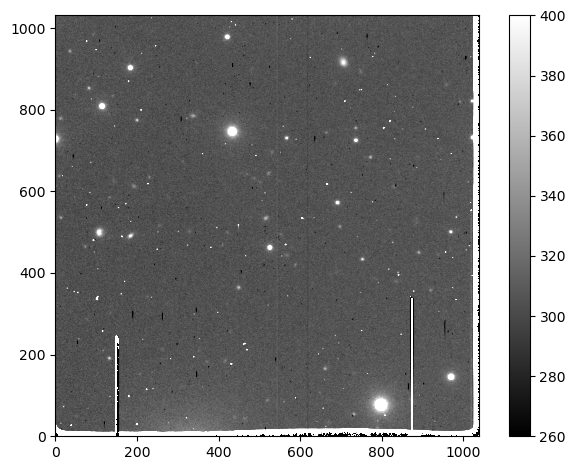

In [3]:
# Science data
data_dir = 'Sampledata_Astro501/'
img_file = data_dir + '0121_grb030329_reduced_astrometry.fits'
data, header = fits.getdata(img_file, header=True)
data = np.nan_to_num(data)  # Make any NaN's = 0

# The MDM keyword for airmass is SECZ
# The MDM keyword for the filter is MISFLTID
# Make sure you adjust the next couple of lines!

# airmass = header['SECZ']
# filt = header['MISFLTID']
airmass = header['AIRMASS']
filt = 'B'

wcs_tranform = wcs.WCS(header)

plt.imshow(data, origin='lower', cmap='gray', vmin=260, vmax=400)
plt.colorbar()
plt.tight_layout()

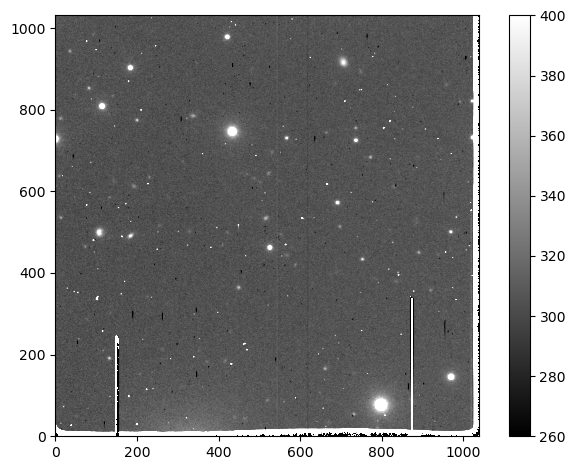

In [4]:
# Standard data

# CHANGE THIS IF STANDARD AND SCIENCE OBJECTS ARE IN DIFFERENT IMAGES
standard_img_file = data_dir + '0121_grb030329_reduced_astrometry.fits'
###

standard_data, standard_header = fits.getdata(standard_img_file, header=True)
standard_data = np.nan_to_num(standard_data)  # Make any NaN's = 0

# The MDM keyword for airmass is SECZ
# The MDM keyword for the filter is MISFLTID
# Make sure you adjust the next couple of lines!

# standard_airmass = standard_header['SECZ']
# standard_filt = standard_header['MISFLTID']
standard_airmass = standard_header['AIRMASS']
standard_filt = 'B'

standard_wcs_tranform = wcs.WCS(standard_header)

plt.imshow(standard_data, origin='lower', cmap='gray', vmin=260, vmax=400)
plt.colorbar()
plt.tight_layout()

## Photometry with a small number of sources with known positions

i.e. photometry with local background subtraction

The approach will be:
1. Record object positions in a catalog file (see `Sampledata_Astro501/object_coords.cat` for an example)
2. Read in object positions using `pandas`
3. Define apertures around the standard star(s)
4. Determine the zero point (i.e. the correction to the instrumental magnitude) using these apertures
5. Define apertures around your science object(s)
6. Calculate magnitude using instrumental mag and zero point!

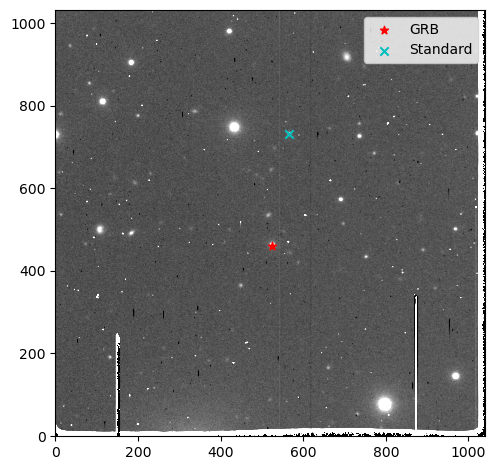

In [5]:
obj_coords_table = pd.read_csv(data_dir+'object_coords.cat', delimiter=',')
obj_coords = SkyCoord(obj_coords_table.ra, obj_coords_table.dec, 
                      unit=(u.hour, u.deg), equinox='J2000')

# Convert sky coordinates to pixels using the WCS
x_pix, y_pix = obj_coords.to_pixel(wcs_tranform)
pix_coords = list(zip(x_pix, y_pix))


plt.imshow(data, origin='lower', cmap='gray', vmin=260, vmax=400)
plt.scatter(x_pix[0], y_pix[0], marker='*', color='r', label='GRB')
plt.scatter(x_pix[1], y_pix[1], marker='x', color='c', label='Standard')
plt.legend()
plt.tight_layout()

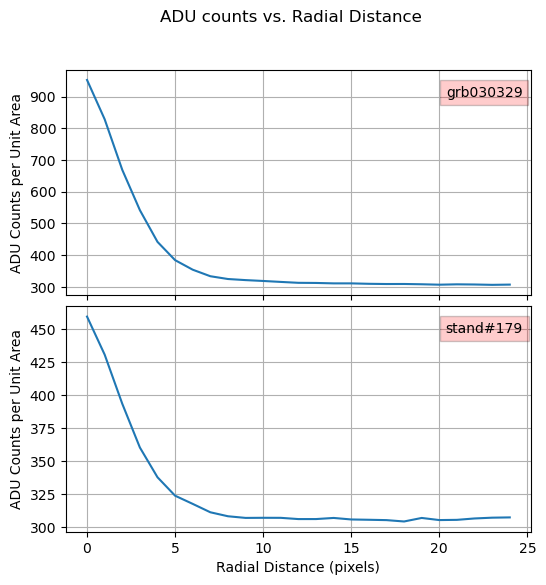

In [6]:
# Plot photon counts as a function of radius given the position
# the source. Useful for determining aperture parameters
def plot_radial_counts(data, source_centroids):
    n_sources = len(source_centroids)
    fig, axes = plt.subplots(n_sources, 1, 
                             sharex=True, figsize=(6, 3*n_sources))

    # Loop over sources
    for i in range(n_sources):
        radius = 0.0001 #changed this from 0 to 0.0001 bc required positive scalar
        radii = []
        photon_counts = []
        
        # Most sources are much smaller than 25 pixels in radius
        # But can definitely increase this value if needed!
        # This also gives a good sense of background counts
        while radius < 25:
            # Create the aperture
            aperture = CircularAnnulus(source_centroids[i],
                                       r_in = radius, r_out = radius+1)
            # Do the photometry
            phot_table = aperture_photometry(data, aperture, method='subpixel')
            
            # Determine number of photon counts per unit area
            photon_counts.append(phot_table['aperture_sum']/aperture.area) #took out () in area()

            radii.append(radius)
            radius += 1
            
        # Plot the data
        # plt.clf()
        axes[i].grid(True)
        axes[i].plot(radii, photon_counts)
        axes[i].set_ylabel("ADU Counts per Unit Area")
        axes[i].text(0.9,0.9, obj_coords_table.name[i], horizontalalignment='center',
                     verticalalignment='center',transform=axes[i].transAxes, 
                     bbox=dict(facecolor='red', alpha=0.2))
        
    fig.subplots_adjust(hspace=0.05)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.suptitle("ADU counts vs. Radial Distance")
    plt.xlabel("Radial Distance (pixels)")
    # plt.ylabel("ADU Counts per Unit Area")
        
plot_radial_counts(data, pix_coords)

In [7]:
radius =0.001
aperture = CircularAnnulus(pix_coords[0],
                                       r_in = radius, r_out = radius+1)
aperture.area

3.147875838896972

Okay, we see a clear peak at r=0 (i.e. the very center of the source) with a fall-off as radius increases. Then it levels off to some constant, non-zero value (the background)

Choose 3 different radii:
* **The source aperture radius** -- where the counts transition to the background value
* **The 2 background annulus radii** -- should encompass a region of pretty constant background value (i.e. don't get too close to the source peak, where it's still falling off a little bit)

In [8]:
# Define your aperture sizes (in pixels)
# Add additional apertures if you have more than two objects
standard_ap, standard_bkg_in, standard_bkg_out = 7, 12, 17
obj_aps, obj_bkgs_in, obj_bkgs_out = 7, 15, 20

In [9]:
def do_ap_photometry(data, source_centroid, r_ap, bg_rin, bg_rout, airmass, filt):
    """
    Args:
        data:            The image data array
        source_centroid: Location of source (pix coordinates)
        r_ap:            Size (in pix) of source aperture
        bg_rin:          Inner radius (in pix) of background annulus
        bg_rout:         Outer radius (in pix) of background annulus
        airmass:         Airmass of the image
        filt:            Filter used for the image
        
    Returns:
        Flux and flux error due to source, background subtracted
    """
    
    # Change to appropriate MDM values
    # Values are likely in FITS header...
    read_noise = 10
    gain = 4
    
    # Create the source and background apertures
    aperture = CircularAperture(source_centroid, r=r_ap)
    bg_aperture = CircularAnnulus(source_centroid,
                                  r_in = bg_rin,
                                  r_out = bg_rout)

    # Do the aperture photometry                              
    rawflux_table = aperture_photometry(data, aperture)
    bkgflux_table = aperture_photometry(data, bg_aperture)

    # Correct for aatmospheric extinction
    rawflux_table['aperture_sum_corr'] = flux_airmass_correction(rawflux_table['aperture_sum'], airmass, filt)
    bkgflux_table['aperture_sum_corr'] = flux_airmass_correction(bkgflux_table['aperture_sum'], airmass, filt)
    
    phot_table = hstack([rawflux_table, bkgflux_table], 
                         table_names=['raw', 'bkg'])

    # Get the mean number of background counts per unit area                    
    bkg_mean = phot_table['aperture_sum_corr_bkg'] / bg_aperture.area #took out ()

    # Calculate number of background counts in source aperture
    bkg_sum = bkg_mean*aperture.area #took out ()

    # Calculate the true number of source photon counts in
    # source aperture
    final_flux = phot_table["aperture_sum_corr_raw"]-bkg_sum
    final_flux_err = np.sqrt(final_flux + bkg_sum + aperture.area*read_noise**2*gain)
    
    print ("Background sum = ", bkg_sum.data, "\n")
    print ("Object Counts = ", final_flux.data, "\n")
    
    return final_flux, final_flux_err


def calculate_zeropoint(data, source_centroid, r_ap,
                        bg_rin, bg_rout, known_mag, airmass, filt):
    """
    Args:
        data:            The image data array
        source_centroid: Location of source (pix coordinates)
        r_ap:            Size (in pix) of source aperture
        bg_rin:          Inner radius (in pix) of background annulus
        bg_rout:         Outer radius (in pix) of background annulus
        airmass:         Airmass of the image
        filt:            Filter used for the image
        
    Returns:
        The zero point magnitude and error
    """

    final_flux, final_flux_err = do_ap_photometry(data, source_centroid, r_ap, 
                                                  bg_rin, bg_rout, airmass, filt)

    # Calculate the zero point using the known magnitude
    zp =  known_mag+2.5*np.log10(final_flux)
    zp_err = np.sqrt( ((-2.5/final_flux)*final_flux_err)**2)
    
    return zp.data, zp_err.data


def calculate_magnitude(data, source_centroid, r_ap, 
                        bg_rin, bg_rout, zeropoint, zeropoint_err,
                        airmass, filt):
    """
    Args:
        data:            The image data array
        source_centroid: Location of source (pix coordinates)
        r_ap:            Size (in pix) of source aperture
        bg_rin:          Inner radius (in pix) of background annulus
        bg_rout:         Outer radius (in pix) of background annulus
        airmass:         Airmass of the image
        filt:            Filter used for the image
        
    Returns:
        The object magnitude and error
    """
    
    final_flux, final_flux_err = do_ap_photometry(data, source_centroid, r_ap, 
                                                  bg_rin, bg_rout, airmass, filt)
    
    # Calculate source magnitude using source photon counts
    # and previously determined zero point
    mag = -2.5*np.log10(final_flux) + zeropoint

    mag_err = np.sqrt( ((-2.5/final_flux)*final_flux_err)**2 + zeropoint_err**2)

    return mag.data, mag_err.data

In [10]:
print("-"*70)
print("| Zero point")
print("-"*70)
zeropoint, zeropoint_err = calculate_zeropoint(standard_data, (x_pix[1], y_pix[1]), 
                                               standard_ap, standard_bkg_in, 
                                               standard_bkg_out, obj_coords_table.mag[1],
                                               standard_airmass, standard_filt)
print("Zeropoint, error = ",zeropoint, zeropoint_err)


print("\n" + "-"*70)
print("| Science Object Mag")
print("-"*70)
obj_mag, obj_err = calculate_magnitude(data, (x_pix[0], y_pix[0]), 
                                       obj_aps, obj_bkgs_in, obj_bkgs_out, 
                                       zeropoint, zeropoint_err,
                                       airmass, filt)
print("Magnitude, error = ",obj_mag, obj_err)

----------------------------------------------------------------------
| Zero point
----------------------------------------------------------------------
Background sum =  [52193.01480919] 

Object Counts =  [6753.73145553] 

Zeropoint, error =  [28.29385947] [0.12850775]

----------------------------------------------------------------------
| Science Object Mag
----------------------------------------------------------------------
Background sum =  [52704.04989831] 

Object Counts =  [28498.27419374] 

Magnitude, error =  [17.15681307] [0.13271398]


------

Ok, our GRB has a magnitude of $17.15 \pm 0.13$

## Photometry with many sources in the same image

The above method gets increasingly tedious with more sources to calculate magnitudes for..this next method can more easily handle an image with many sources that we want magnitudes for. We'll use one of `photutils`'s source finding routines, just to try to automate things a bit better

This part will focus on the science image, since I'll assume your standard star is the only source of interest in the standard image. Now let's find the sources in our science image. I'll use `photutils`'s [image segmentation](http://photutils.readthedocs.io/en/stable/photutils/segmentation.html) technique, but there are various different methods you can use. You can check them out on the `photutils` [documentation page](http://photutils.readthedocs.io/en/stable/index.html).

In [11]:
# First, determine the 2D background map of your image
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
threshold = bkg.background + (3. * bkg.background_rms)

# Remember to change the gain to the correct value for MDM
gain = 4
error = calc_total_error(data, bkg_error=bkg.background_rms, effective_gain=gain)

segmented_img = detect_sources(data, threshold, npixels=5)
props = SourceCatalog(data, segmented_img, 
                          error=error, wcs=wcs_tranform, background=bkg.background)

#tbl = properties_table(props)
tbl = props.to_table(columns=['label','xcentroid','ycentroid','sky_centroid','bbox_xmin','bbox_xmax','bbox_ymin','bbox_ymax','area','semimajor_sigma','semiminor_sigma','orientation','eccentricity','min_value','max_value','local_background','segment_flux','segment_fluxerr','kron_flux','kron_fluxerr', "sky_centroid_icrs"])
print(tbl)
# Use print(tbl.columns) to see what data is contained in this table

label     xcentroid      ...    kron_fluxerr              sky_centroid_icrs          
                         ...                                   deg,deg               
----- ------------------ ... ------------------ -------------------------------------
    1  87.74902329350647 ...  7878.518592387426 161.29627869790852,21.441737012707556
    2  793.4444719528774 ... 14020.191134334033  161.1542456131638,21.483114733803387
    3  610.8250168912222 ...                nan  161.19101320651185,21.43563869022618
    4  672.8270121082137 ...                nan 161.17853902608917,21.435762668136594
    5  682.8278582109142 ...                nan 161.17652769099507,21.435637513503448
    6   855.458541830406 ...                nan 161.14180896643313,21.435669023752368
  ...                ... ...                ...                                   ...
  157 421.25147695294817 ...  792.1709414498087 161.22960736099813,21.617930163201716
  158  576.3520964714511 ...  140.7743857231936   161.

In [12]:
for prop in props:
    print(prop.xcentroid)

87.74902329350647
793.4444719528774
610.8250168912222
672.8270121082137
682.8278582109142
855.458541830406
1035.3199214751521
700.3799801096989
1030.7654265143194
1036.7126646392196
338.3706034955149
789.4330298713273
662.2154642404894
39.41769297604111
199.99357781078663
152.68260013238498
789.9258782890954
320.87533807449773
801.6000667168868
797.2327411459157
731.1297695024887
1038.0618737553325
153.11842068688551
655.9041641261664
876.0
876.0
825.7951947098431
819.3180957047698
588.39932258833
180.62973747684728
876.0
797.0081495551852
223.68390838482176
361.0
968.5922166807518
764.1875535334235
660.5157170978172
152.66853250589196
431.1721971747068
416.85988754253646
132.74195813055084
282.36420713100074
339.0052265432278
469.5565228153055
654.8319766208039
0.0
462.76983522638386
693.1855460958736
685.7736797900761
846.6430821880571
116.04340939178276
750.219954417856
1038.4225740286429
0.0
102.52572873597255
981.10625545284
0.0
869.5365783148243
569.1488351480448
161.470511695799

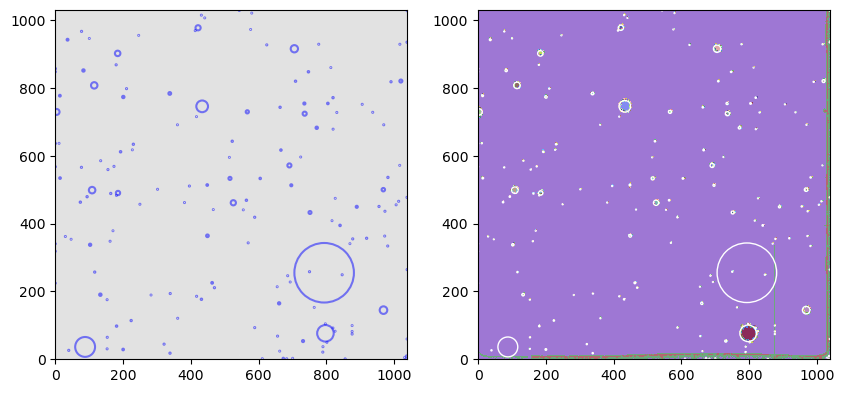

In [13]:
r = 5.    # approximate isophotal extent, i.e. your best guess for source aperture size
apertures = []
for prop in props:
    position = (prop.xcentroid, prop.ycentroid) #deleted .value
    r_new = prop.equivalent_radius.value
    apertures.append(CircularAperture(position, r=r_new))


rand_cmap = make_random_cmap(segmented_img.data.max() + 1)# segmented_img.max -> semgented_img.data.max()
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax2.imshow(segmented_img, origin='lower', cmap=rand_cmap)
for aperture in apertures:
    aperture.plot(color='blue', lw=1.5, alpha=0.5, axes=ax1) #ax -> axes
    aperture.plot(color='white', lw=1.0, alpha=1.0, axes=ax2)


The image defects create some strange apertures....but the actual sources themselves look fine!

Now let's correct for atmospheric extinction and calculate object magnitudes. Best part: you can use the exact method from above to calculate the zero point! The only difference between this method and the last is what you do with the science image -- the standard image is treated exactly the same!

In [14]:
tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr,sky_centroid_icrs
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,,"deg,deg"
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
1,87.74902329350647,35.96112196169848,"161.29628332106006,21.441732845806097",0,154,0,247,2702.0,74.70522547642052,38.55788057226829,55.76062832106753,0.8565080601441245,338.30360110798364,145170.5433962391,0.0,9635417.838165129,1651.5169577906815,97553081.99663594,7878.518592387426,"161.29627869790852,21.441737012707556"
2,793.4444719528774,254.9397273291947,"161.15425023669624,21.483110555944766",154,1039,0,1031,24273.0,392.0171616438545,183.04007008683033,51.63607717003017,0.8843003462920661,333.0414202708101,4080100.9860933176,0.0,75978662.15688607,4597.242613445158,361623250.26133937,14020.191134334033,"161.1542456131638,21.483114733803387"
3,610.8250168912222,1.327039680220194,"161.19101783321562,21.43563451520155",610,611,0,3,5.0,0.9483266136988574,0.3742007746825356,85.66523132081524,0.9188570358933041,2255.0285714285505,4546.470346598183,0.0,17022.911365700144,68.70997652863278,nan,nan,"161.19101320651185,21.43563869022618"
4,672.8270121082137,1.763150264181456,"161.17854365313883,21.435758492150274",668,676,0,3,15.0,2.7416479287902504,0.8344779889726559,21.031937340277693,0.9525535805594517,693.9068181819663,8216.535779816504,0.0,57346.99060947679,125.35685484501897,nan,nan,"161.17853902608917,21.435762668136594"
5,682.8278582109142,1.0569963290244297,"161.17653231811343,21.435633337362084",681,684,0,3,6.0,1.102422963764804,0.9948539906677709,15.147078360474726,0.43084707864287775,1030.6126582277952,5259.083253588566,0.0,18728.40344955352,72.34119108802588,nan,nan,"161.17652769099507,21.435637513503448"
6,855.458541830406,0.6126884533877286,"161.14181359454253,21.43566484493555",853,858,0,1,7.0,1.0600730126590734,0.440842605477829,-12.415088769154186,0.9094283679072352,1026.282352941177,14762.676923076953,0.0,30133.91168484455,90.43836850371395,nan,nan,"161.14180896643313,21.435669023752368"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,576.3520964714511,973.2108577022835,"161.1986065364435,21.61702425503292",575,578,973,974,5.0,0.9746316742007636,0.3992014982659577,-5.412954400855885,0.9122687420591249,335.58157004912,481.39592560427263,0.0,1892.165283604908,29.981356994974494,37676.87880728452,140.7743857231936,"161.1986019261202,21.61702842947242"


In [15]:
tbl['source_sum_corr'] = flux_airmass_correction(tbl['segment_flux'], airmass, filt)
tbl['source_mag'] = -2.5*np.log10(tbl['source_sum_corr']) + zeropoint
tbl['source_mag_err'] = np.sqrt( ((-2.5/tbl['source_sum_corr'])*tbl['segment_fluxerr'])**2 
                                + zeropoint_err**2
                               )

Now, for this particular example, we're only interested in a single object: the GRB. But the previous cell will give you the magnitudes for **every** source detected in the image, so you can do with that what you will. 

------

For the next cell, I'll just select the GRB by putting positional constraints on the RA and dec.

In [16]:
tbl[121]

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr,sky_centroid_icrs,source_sum_corr,source_mag,source_mag_err
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,,"deg,deg",,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64
122,735.9232261723473,724.5519858210894,"161.1662256951405,21.570693438785927",730,742,719,731,113.0,2.977205840329769,2.9092693723672864,-68.17950938376931,0.21240771135471312,333.3593414443541,597.1629395029256,0.0,44515.96193330761,144.00556007930686,807361.2697043999,649.6576801721366,"161.16622107975192,21.57069761572168",49296.24047301471,16.561824971348614,0.12871509811277465


In [17]:
pos_error = 3/3600. * u.deg  # Allow wiggle room of 3 arcsec
ra_cond = (np.abs(tbl['sky_centroid_icrs'].ra - obj_coords[1].ra) < pos_error)
dec_cond = (np.abs(tbl['sky_centroid_icrs'].dec - obj_coords[1].dec) < pos_error)

obj_tbl = tbl[ra_cond & dec_cond]
print(obj_tbl)

label     xcentroid         ycentroid     ...     source_mag       source_mag_err  
                                          ...                                      
----- ----------------- ----------------- ... ----------------- -------------------
  123 566.6001742525448 730.0326801538231 ... 17.13921896783686 0.12887375707079288


Perfect, one object satisfies our ra and dec positional criteria! This is our GRB. You can see that its magnitude is the same as the previous method (within error) -- $17.14 \pm 0.13$